Basic EDA

In [1]:
import sys
sys.path.append('..')
from src.features.build import build_all_features
from src.data.preprocessing import build_main_dataset
from src.features.engineering import create_diffs


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plt.style.use('seaborn-v0_8-dark')
sns.set_palette("husl")
%matplotlib inline

In [2]:
df_raw = build_main_dataset(
    target_ticker= "PETR4.SA",
    target_name= 'petr4',
    aux_tickers= {'^BVSP':'ibov', '^GSPC':'sp500', 'BZ=F':'brent', 'USDBRL=X':'x_rate', '^VIX':'vix'},  # ex: {'^BVSP': 'ibov', 'CL=F': 'petroleo'}
    start= "2016-01-01",
    end=  None,
    dir=  'data/raw',
    indicadores_bcb = {'selic': 432}
)

Carregando PETR4.SA de data/raw\PETR4.SA_2016-01-01_2025-11-13.csv
Carregando ^BVSP de data/raw\BVSP_2016-01-01_2025-11-13.csv
Carregando ^GSPC de data/raw\GSPC_2016-01-01_2025-11-13.csv
Carregando BZ=F de data/raw\BZ_F_2016-01-01_2025-11-13.csv
Carregando USDBRL=X de data/raw\USDBRL_X_2016-01-01_2025-11-13.csv
Carregando ^VIX de data/raw\VIX_2016-01-01_2025-11-13.csv
Dataset final salvo em data/processed/petr4_completo.csv


In [3]:
df = build_all_features(
    df=df_raw,
    target_price_col="petr4",
    exog_price_cols=["ibov", "sp500","brent",'x_rate'],
    volume_col="Volume",  # se tiver
    vix_col='^VIX',
    econ_ind=['selic'],
    windows=[5, 22, 63],
    lags=[5, 10, 22]
)

print(df.shape)

(2256, 163)


Plots das séries e ADF

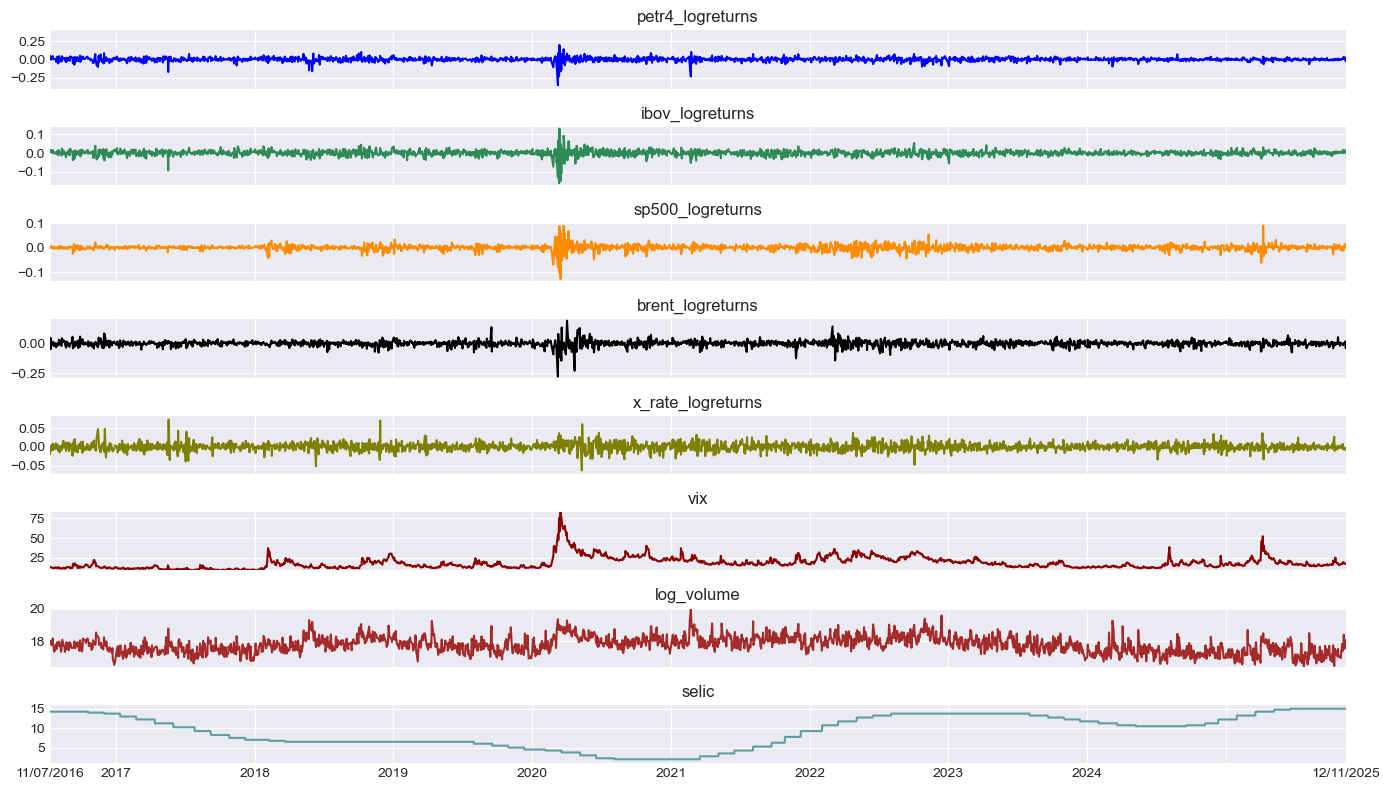

In [8]:
from src.features import plotting_aux
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

variables = ['log_return', 'ibov_logreturns', 'sp500_logreturns','brent_logreturns','x_rate_logreturns','vix','log_volume','selic']
colors = ['blue', 'seagreen', 'darkorange', 'black','olive','darkred','brown','cadetblue']

fig, axes = plt.subplots(8,1,figsize=(14,8),sharex=True)

for axis in axes:
    axis.grid(True, alpha=0.95)

axes[0].plot(df['Date'],df['log_return'],color = 'blue')
axes[0].set_title('petr4_logreturns')

date_min = df['Date'].min()
date_max = df['Date'].max()
axes[0].set_xlim(date_min, date_max)
current_ticks = axes[0].get_xticks()
date_min_num = mdates.date2num(date_min)
date_max_num = mdates.date2num(date_max)
new_ticks = sorted(list(set(current_ticks) | {date_min_num, date_max_num}))
final_ticks = [tick for tick in new_ticks if date_min_num <= tick <= date_max_num]
axes[0].set_xticks(final_ticks)
smart_formatter = plotting_aux.create_smart_date_formatter(date_min, date_max)
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(smart_formatter))
axes[0].set_ylim(-0.4, 0.4)


for p in range(1,8):
    var = variables[p]
    color = colors[p]
    axes[p].plot(df['Date'], df[var], color=color)
    axes[p].set_title(var)
    min_val = (df[var].min()-0.01)
    max_val = (df[var].max()+0.01)
    if p==7:
        min_val = (df[var].min()-1)
        max_val = (df[var].max()+1)
    axes[p].set_ylim(min_val,max_val)


plt.tight_layout()
plt.show()


In [5]:
from src.features.stationarity import adf_series

adf_series(df, variables)

,info,log_return,ibov_logreturns,sp500_logreturns,brent_logreturns,x_rate_logreturns,vix,log_volume,selic
0,statistics,-12.395041,-8.841647,-15.082869,-45.61056,-54.174945,-5.171113,-5.014161,-0.693323
1,p-value,0.0,0.0,0.0,0.0,0.0,0.00001,0.000021,0.848472
2,stationarity,stationary,stationary,stationary,stationary,stationary,stationary,stationary,non-stationary
